In [1]:
import os
import math
import mldatasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt
import seaborn as sns
from alibi.explainers import IntegratedGradients
from distython import HEOM
import shap
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp
from SALib.sample.saltelli import sample as ss
from SALib.analyze.sobol import analyze as sa
from SALib.plotting.bar import plot as barplot

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.2.0


In [3]:
traffic_df = mldatasets.load("traffic-volume", prepare=True)

https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter9/data/Metro_Interstate_Traffic_Volume.csv.gz
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter9/data folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter9/data/Metro_Interstate_Traffic_Volume.csv.gz


In [4]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25656 entries, 2015-10-28 00:00:00 to 2018-09-30 23:00:00
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dow              25656 non-null  int64  
 1   hr               25656 non-null  int64  
 2   temp             25656 non-null  float64
 3   rain_1h          25656 non-null  float64
 4   cloud_coverage   25656 non-null  float64
 5   is_holiday       25656 non-null  int64  
 6   traffic_volume   25656 non-null  float64
 7   weather_Clear    25656 non-null  uint8  
 8   weather_Clouds   25656 non-null  uint8  
 9   weather_Haze     25656 non-null  uint8  
 10  weather_Mist     25656 non-null  uint8  
 11  weather_Other    25656 non-null  uint8  
 12  weather_Rain     25656 non-null  uint8  
 13  weather_Snow     25656 non-null  uint8  
 14  weather_Unknown  25656 non-null  uint8  
dtypes: float64(4), int64(3), uint8(8)
memory usage: 1.8 MB


In [5]:
autocorr = acf(traffic_df.traffic_volume, unbiased=True,\
               fft=True, alpha=.05, nlags=8736)
print(autocorr[0].shape)

(8737,)


In [6]:
print(autocorr[0][1:].argmax())

8735


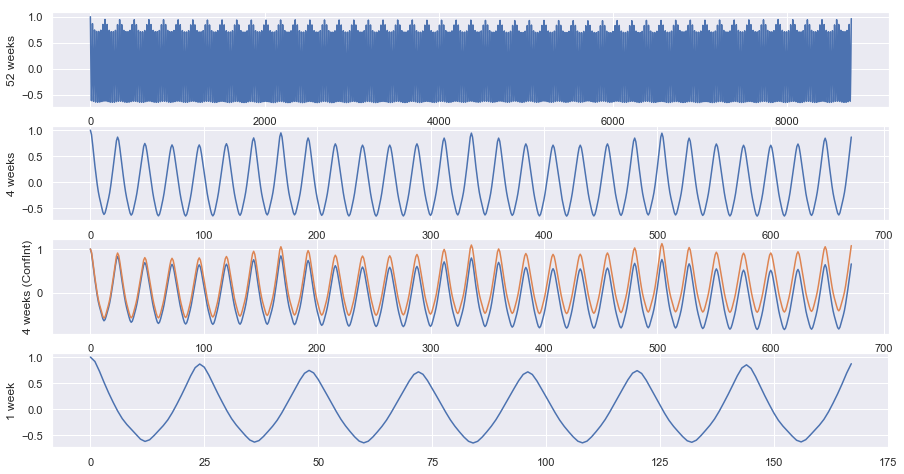

In [27]:
orig_plt_params = plt.rcParams
sns.set()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8))
ax0.plot(np.linspace(0,8736,8737), autocorr[0])
ax0.set_ylabel('52 weeks')
ax1.plot(np.linspace(0,671,672), autocorr[0][:672])
ax1.set_ylabel('4 weeks')
ax2.plot(np.linspace(0,671,672), autocorr[1][:672,:])
ax2.set_ylabel('4 weeks (ConfInt)')
ax3.plot(np.linspace(0,167,168), autocorr[0][:168])
ax3.set_ylabel('1 week')
plt.show()

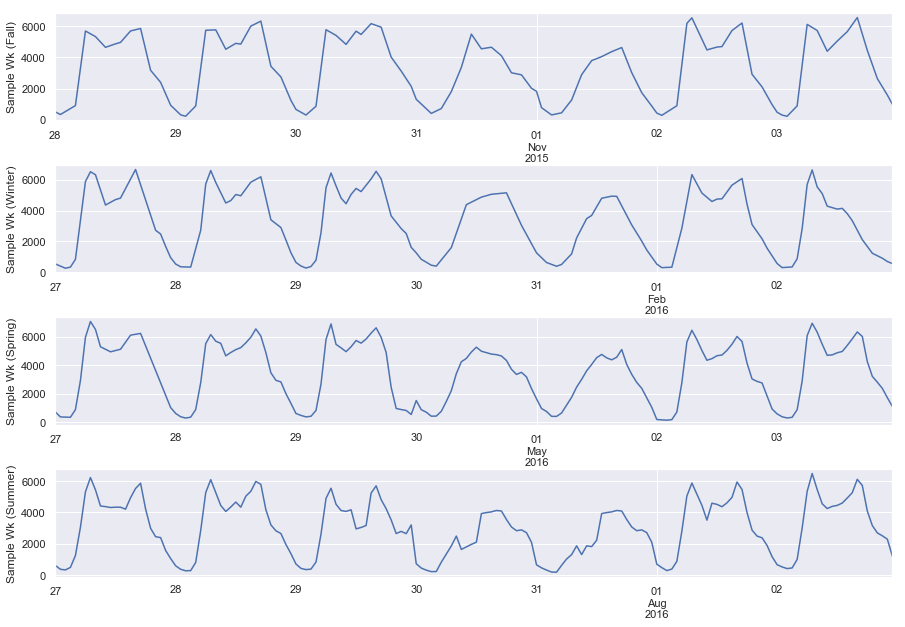

In [29]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4)
traffic_df[:168].traffic_volume.\
                plot(ax=ax0, ylabel='Sample Wk (Fall)')
traffic_df[(168*13):(168*14)].traffic_volume.\
                plot(ax=ax1, ylabel='Sample Wk (Winter)')
traffic_df[(168*26):(168*27)].traffic_volume.\
                plot(ax=ax2, ylabel='Sample Wk (Spring)')
traffic_df[(168*39):(168*40)].traffic_volume.\
                plot(ax=ax3, ylabel='Sample Wk (Summer)',\
                     xlabel='')
plt.show()

<Figure size 864x576 with 0 Axes>

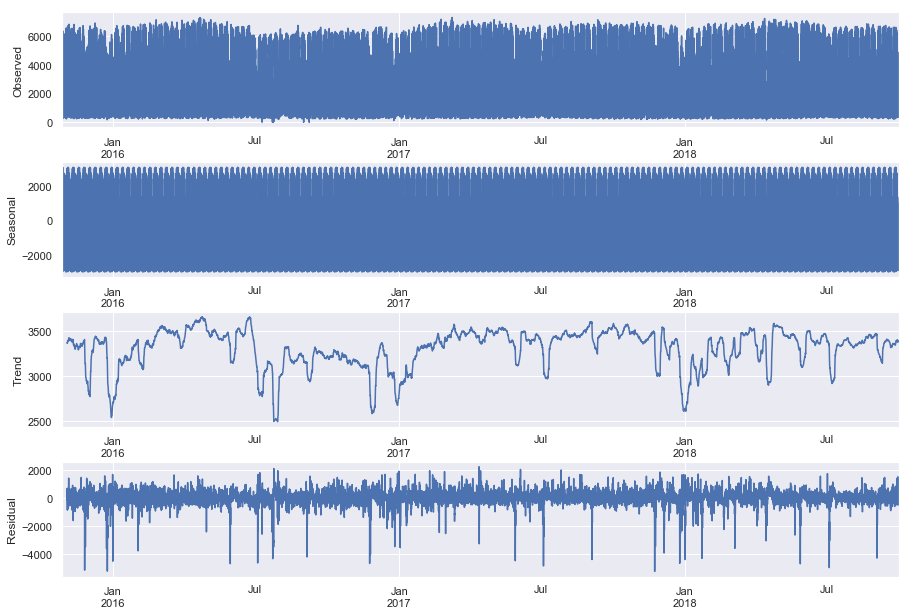

In [40]:
plt.figure(figsize=(12,8))
decomp = seasonal_decompose(traffic_df.traffic_volume,\
                            model='additive', period=168, 
                            two_sided=False)

fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3)
decomp.observed.plot(ax=ax0, ylabel='Observed', xlabel='')
decomp.seasonal.plot(ax=ax1, ylabel='Seasonal', xlabel='')
decomp.trend.plot(ax=ax2, ylabel='Trend', xlabel='')
decomp.resid.plot(ax=ax3, ylabel='Residual', xlabel='')
plt.show()

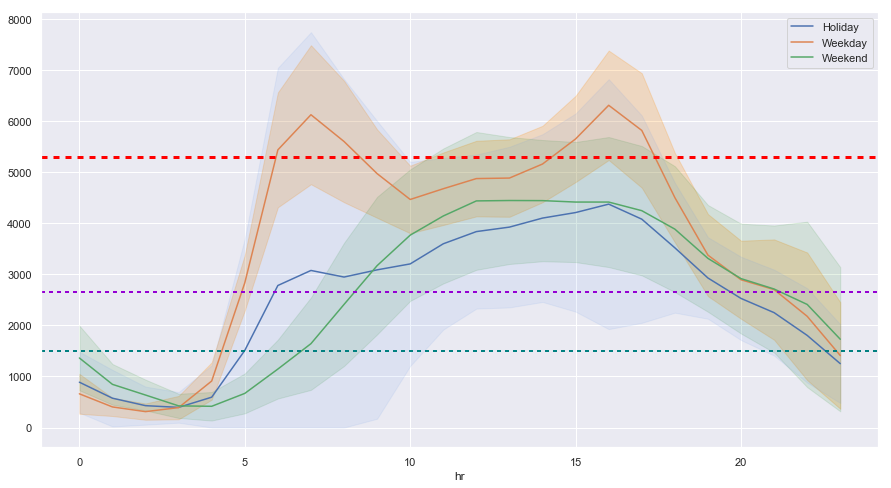

In [318]:
weekend_df = traffic_df[['hr', 'dow', 'is_holiday', 'traffic_volume']].copy()
weekend_df['type_of_day'] = np.where(weekend_df.is_holiday == 1, 'Holiday',
                                   np.where(weekend_df.dow >= 5, 'Weekend', 'Weekday'))
weekend_df = weekend_df.groupby(['type_of_day','hr'])['traffic_volume'].agg(['mean','std']).\
                reset_index().pivot(index='hr', columns='type_of_day', values=['mean', 'std'])
weekend_df.columns = ['_'.join(col).strip().replace('mean_','')\
                      for col in weekend_df.columns.values]
fig, ax = plt.subplots(figsize=(15,8))
weekend_df[['Holiday','Weekday','Weekend']].plot(ax=ax)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Weekday - 2 * weekend_df.std_Weekday, 0),\
                 weekend_df.Weekday + 2 * weekend_df.std_Weekday,
                 color='darkorange', alpha=0.2)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Weekend - 2 * weekend_df.std_Weekend, 0),\
                 weekend_df.Weekend + 2 * weekend_df.std_Weekend,
                 color='green', alpha=0.1)
plt.fill_between(weekend_df.index,\
                 np.maximum(weekend_df.Holiday - 2 * weekend_df.std_Holiday, 0),\
                 weekend_df.Holiday + 2 * weekend_df.std_Holiday,
                 color='cornflowerblue', alpha=0.1)
ax.axhline(y=5300, linewidth=3, color='red', dashes=(2,2))
ax.axhline(y=2650, linewidth=2, color='darkviolet', dashes=(2,2))
ax.axhline(y=1500, linewidth=2, color='teal', dashes=(2,2))
plt.show()

In [11]:
train = traffic_df[:-4368]
valid = traffic_df[-4368:-2184]
test = traffic_df[-2184:]

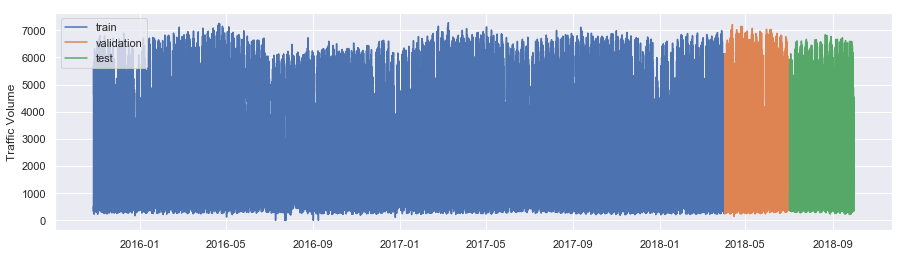

In [12]:
plt.figure(figsize=(15,4))
plt.plot(train.index.values, train.traffic_volume.values,\
         label='train')
plt.plot(valid.index.values, valid.traffic_volume.values,\
         label='validation')
plt.plot(test.index.values, test.traffic_volume.values,\
         label='test')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [13]:
y_scaler = MinMaxScaler()
y_scaler.fit(traffic_df[['traffic_volume']])
X_scaler = MinMaxScaler()
X_scaler.fit(traffic_df.drop(['traffic_volume'], axis=1))

MinMaxScaler()

In [14]:
y_train = y_scaler.transform(train[['traffic_volume']])
X_train = X_scaler.transform(train.drop(['traffic_volume'], axis=1))
y_test = y_scaler.transform(test[['traffic_volume']])
X_test = X_scaler.transform(test.drop(['traffic_volume'], axis=1))

In [93]:
gen_train_672 = TimeseriesGenerator(X_train, y_train, length=672, batch_size=24)
gen_test_672 = TimeseriesGenerator(X_test, y_test, length=672, batch_size=24)

print("gen_train_672:\t%s\t×\t%s\t→\t%s" % (len(gen_train_672),\
                                    gen_train_672[0][0].shape,\
                                    gen_train_672[0][1].shape))
print("gen_test_672:\t%s\t×\t%s\t→\t%s" % (len(gen_test_672),\
                                   gen_test_672[0][0].shape,\
                                   gen_test_672[0][1].shape))

gen_train_672:	859	×	(24, 672, 14)	→	(24, 1)
gen_test_672:	63	×	(24, 672, 14)	→	(24, 1)


In [94]:
gen_train_168 = TimeseriesGenerator(X_train, y_train, length=168,\
                                    batch_size=24)
gen_test_168 = TimeseriesGenerator(X_test, y_test, length=168,\
                                   batch_size=24)

print("gen_train_168:\t%s\t×\t%s\t→\t%s" % (len(gen_train_168),\
                                    gen_train_168[0][0].shape,\
                                    gen_train_168[0][1].shape))
print("gen_test_168:\t%s\t×\t%s\t→\t%s" % (len(gen_test_168),\
                                   gen_test_168[0][0].shape,\
                                   gen_test_168[0][1].shape))

gen_train_168:	880	×	(24, 168, 14)	→	(24, 1)
gen_test_168:	84	×	(24, 168, 14)	→	(24, 1)


In [154]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

In [109]:
model_path = get_file('LSTM_traffic_672_final.hdf5',\
            'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/LSTM_traffic_672_final.hdf5?raw=true')
lstm_traffic_672_mdl = keras.models.load_model(model_path)
lstm_traffic_672_mdl.summary()

11378688/11372296 [==============================] - 5s 0us/step
Model: "Traffic_Bidirectional_LSTM_672"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bidir_LSTM (Bidirectional)   (24, 672)                 943488    
_________________________________________________________________
Dropout (Dropout)            (24, 672)                 0         
_________________________________________________________________
Dense (Dense)                (24, 1)                   673       
Total params: 944,161
Trainable params: 944,161
Non-trainable params: 0
_________________________________________________________________


In [113]:
model_path = get_file('LSTM_traffic_168_final.hdf5',\
            'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/LSTM_traffic_168_final.hdf5?raw=true')
lstm_traffic_168_mdl = keras.models.load_model(model_path)
lstm_traffic_168_mdl.summary()

1507328/1506256 [==============================] - 0s 0us/step
Model: "Traffic_LSTM_168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (24, 168)                 122976    
_________________________________________________________________
Dropout (Dropout)            (24, 168)                 0         
_________________________________________________________________
Dense (Dense)                (24, 1)                   169       
Total params: 123,145
Trainable params: 123,145
Non-trainable params: 0
_________________________________________________________________


Traffic_Bidirectional_LSTM_672
63/63 [==============================] - 18s 293ms/step


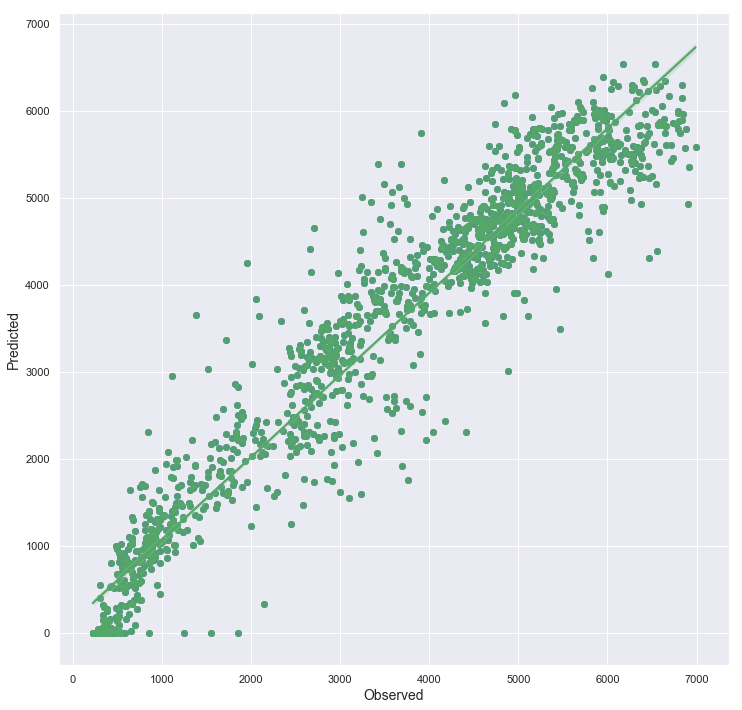

RMSE_train: 537.1589	RMSE_test: 542.6649	r2: 0.9263

Traffic_LSTM_168
84/84 [==============================] - 2s 29ms/step


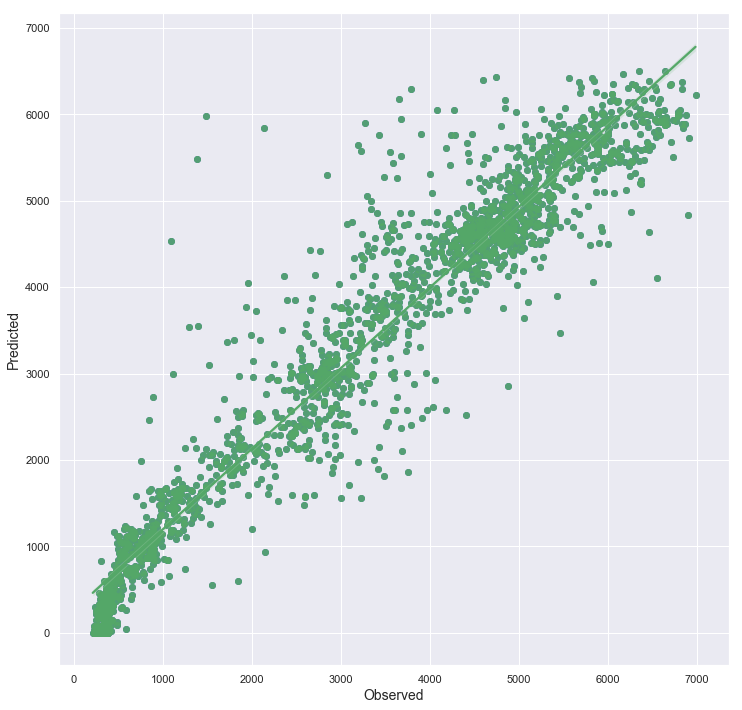

RMSE_train: 473.4274	RMSE_test: 561.8984	r2: 0.9187


In [267]:
print(lstm_traffic_672_mdl.name+"\r\n"+("="*100))
y_train_pred_672, y_test_pred_672, y_train_672, y_test_672 =\
    mldatasets.evaluate_reg_mdl(lstm_traffic_672_mdl, gen_train_672, gen_test_672,\
                             y_train, y_test, scaler=y_scaler, y_truncate=True,\
                             predopts={"verbose":1})

print('\r\n'+lstm_traffic_168_mdl.name+"\r\n"+("="*100))
y_train_pred_168, y_test_pred_168, y_train_168, y_test_168 =\
    mldatasets.evaluate_reg_mdl(lstm_traffic_168_mdl, gen_train_168, gen_test_168,\
                             y_train, y_test, scaler=y_scaler, y_truncate=True,\
                             predopts={"verbose":1})

In [236]:
evaluate_672_df = test.iloc[-y_test_pred_672.shape[0]:,[0,1,5,6]].\
                rename(columns={'traffic_volume':'actual_traffic'})
evaluate_672_df['predicted_traffic'] = y_test_pred_672
evaluate_672_df['type_of_day'] = np.where(evaluate_672_df.is_holiday == 1, 'Holiday',
                                   np.where(evaluate_672_df.dow >= 5, 'Weekend', 'Weekday'))
evaluate_672_df.drop(['dow','is_holiday'], axis=1, inplace=True)

evaluate_168_df = test.iloc[-y_test_pred_168.shape[0]:,[0,1,5,6]].\
                rename(columns={'traffic_volume':'actual_traffic'})
evaluate_168_df['predicted_traffic'] = y_test_pred_168
evaluate_168_df['type_of_day'] = np.where(evaluate_168_df.is_holiday == 1, 'Holiday',
                                   np.where(evaluate_168_df.dow >= 5, 'Weekend', 'Weekday'))
evaluate_168_df.drop(['dow','is_holiday'], axis=1, inplace=True)

In [237]:
evaluate_672_df

,hr,actual_traffic,predicted_traffic,type_of_day
date_time,,,,
2018-07-30 00:00:00,0,640.0,998.761108,Weekday
2018-07-30 01:00:00,1,384.0,64.304565,Weekday
2018-07-30 02:00:00,2,317.0,0.000000,Weekday
2018-07-30 03:00:00,3,333.0,298.437378,Weekday
2018-07-30 04:00:00,4,915.0,1508.385254,Weekday
...,...,...,...,...
2018-09-30 19:00:00,19,3543.0,3202.212646,Weekend
2018-09-30 20:00:00,20,2781.0,2687.730713,Weekend
2018-09-30 21:00:00,21,2159.0,2144.519287,Weekend


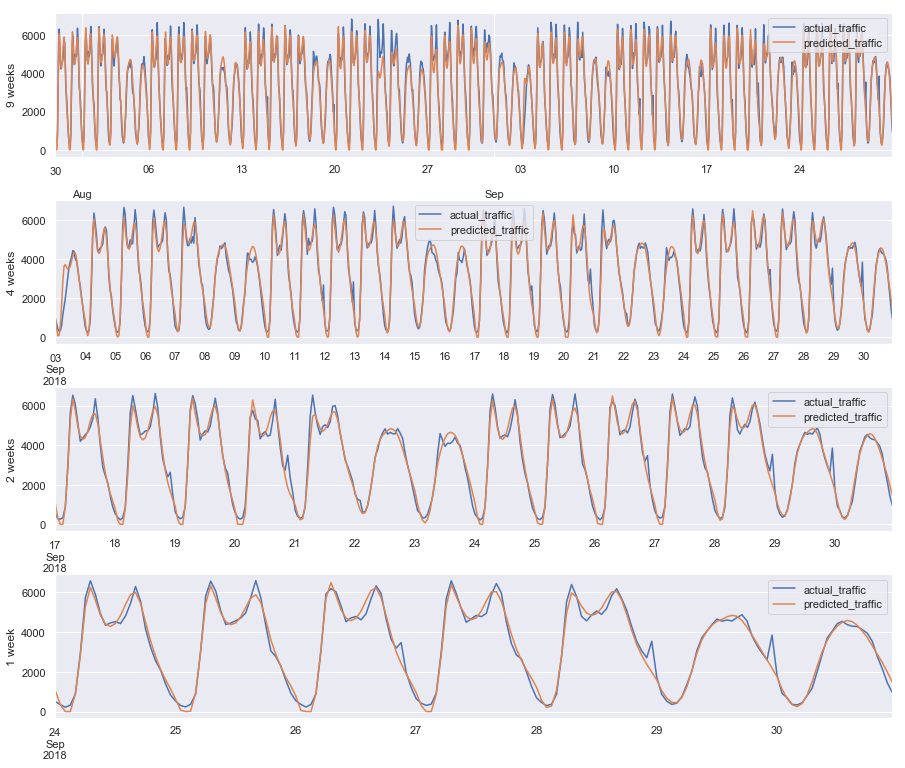

In [284]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,10))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3)
evaluate_168_df.iloc[-1512:,[1,2]].plot(ax=ax0, ylabel='9 weeks')
evaluate_168_df.iloc[-672:,[1,2]].plot(ax=ax1, ylabel='4 weeks')
evaluate_168_df.iloc[-336:,[1,2]].plot(ax=ax2, ylabel='2 weeks')
evaluate_168_df.iloc[-168:,[1,2]].plot(ax=ax3, ylabel='1 week',\
                                       xlabel='')
plt.show()

In [305]:
def rmse(g):
    rmse = np.sqrt(metrics.\
                   mean_squared_error(g['actual_traffic'],\
                                      g['predicted_traffic']))
    return pd.Series({'rmse': rmse})

evaluate_by_hr_672_df = evaluate_672_df.\
                        groupby(['type_of_day', 'hr']).apply(rmse).reset_index().\
                        pivot(index='hr', columns='type_of_day', values='rmse')
evaluate_by_hr_168_df = evaluate_168_df.\
                        groupby(['type_of_day', 'hr']).apply(rmse).reset_index().\
                        pivot(index='hr', columns='type_of_day', values='rmse')
mean_by_daytype_672_s = evaluate_by_hr_672_df.mean(axis=0)
mean_by_daytype_168_s = evaluate_by_hr_168_df.mean(axis=0)

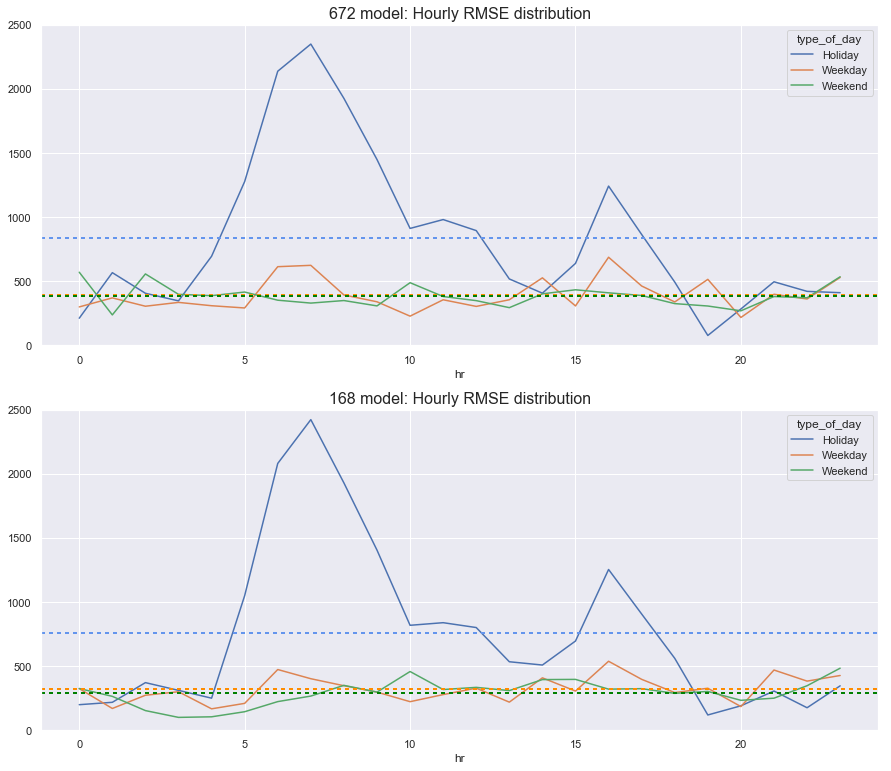

In [317]:
fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(15,10))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2)

evaluate_by_hr_672_df.plot(ax=ax0)
ax0.set_title('672 model: Hourly RMSE distribution', fontsize=16)
ax0.set_ylim([0,2500])
ax0.axhline(y=mean_by_daytype_672_s.Holiday, linewidth=2,\
            color='cornflowerblue', dashes=(2,2))
ax0.axhline(y=mean_by_daytype_672_s.Weekday, linewidth=2,\
            color='darkorange', dashes=(2,2))
ax0.axhline(y=mean_by_daytype_672_s.Weekend, linewidth=2,\
            color='green', dashes=(2,2))

evaluate_by_hr_168_df.plot(ax=ax1)
ax1.set_title('168 model: Hourly RMSE distribution', fontsize=16)
ax1.set_ylim([0,2500])
ax1.axhline(y=mean_by_daytype_168_s.Holiday, linewidth=2,\
           color='cornflowerblue', dashes=(2,2))
ax1.axhline(y=mean_by_daytype_168_s.Weekday, linewidth=2,\
           color='darkorange', dashes=(2,2))
ax1.axhline(y=mean_by_daytype_168_s.Weekend, linewidth=2,\
           color='green', dashes=(2,2))
plt.show()

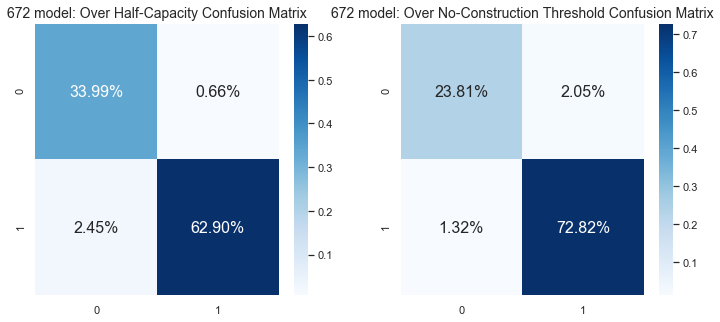

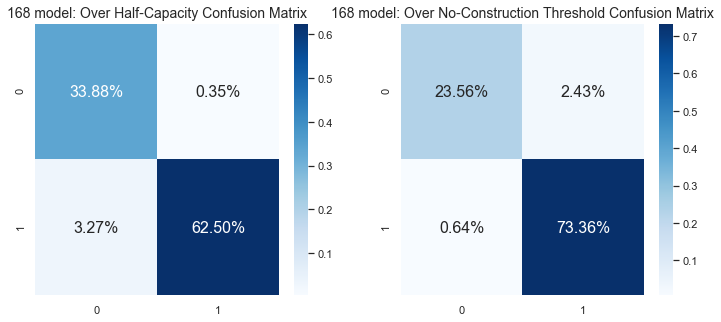

In [322]:
evaluate_dfs = [evaluate_672_df, evaluate_168_df]
lookbacks = [672, 168]

for e in range(2):
    evaluate_df = evaluate_dfs[e]
    lb = lookbacks[e]

    actual_over_half_cap = np.where(evaluate_df['actual_traffic'] >\
                                    2650, 1, 0)
    pred_over_half_cap = np.where(evaluate_df['predicted_traffic'] >\
                                  2650, 1, 0)
    actual_over_nc_thresh = np.where(evaluate_df['actual_traffic'] >\
                                    1500, 1, 0)
    pred_over_nc_thresh = np.where(evaluate_df['predicted_traffic'] >\
                                  1500, 1, 0)

    mldatasets.\
        compare_confusion_matrices(actual_over_half_cap, pred_over_half_cap,\
                                   actual_over_nc_thresh, pred_over_nc_thresh,\
                                   str(lb)+' model: Over Half-Capacity',\
                                   str(lb)+' model: Over No-Construction Threshold')

In [126]:
y_all = y_scaler.transform(traffic_df[['traffic_volume']])
X_all = X_scaler.transform(traffic_df.drop(['traffic_volume'], axis=1))
gen_all_672 = TimeseriesGenerator(X_all, y_all, length=672, batch_size=24)
gen_all_168 = TimeseriesGenerator(X_all, y_all, length=168, batch_size=24)
print("gen_all_678:\t%s\t×\t%s\t→\t%s" % (len(gen_all_672),\
                                    gen_all_672[0][0].shape,\
                                    gen_all_672[0][1].shape))
print("gen_all_168:\t%s\t×\t%s\t→\t%s" % (len(gen_all_168),\
                                    gen_all_168[0][0].shape,\
                                    gen_all_168[0][1].shape))

gen_all_678:	1041	×	(24, 672, 14)	→	(24, 1)
gen_all_168:	1062	×	(24, 168, 14)	→	(24, 1)


In [129]:
X_df = traffic_df.drop(['traffic_volume'], axis=1).reset_index(drop=True)

holiday_afternoon_s = X_df[(X_df.index >= 23471) & (X_df.dow==0) &\
                           (X_df.hr==16) & (X_df.is_holiday==1)]
peak_morning_s = X_df[(X_df.index >= 23471) & (X_df.dow==2) &\
                      (X_df.hr==8) & (X_df.weather_Clouds==1) &\
                      (X_df.temp<20)]
hot_saturday_s = X_df[(X_df.index >= 23471) & (X_df.dow==5) &\
                      (X_df.hr==12) & (X_df.temp>29)]

In [326]:
ig_672  = IntegratedGradients(lstm_traffic_672_mdl,\
                        n_steps=25, internal_batch_size=24)
ig_168  = IntegratedGradients(lstm_traffic_168_mdl,\
                        n_steps=25, internal_batch_size=24)

In [126]:
nidx = holiday_afternoon_s.index.tolist()[0] - 672
holiday_afternoon_X = gen_all_672[nidx//24][0]
print(holiday_afternoon_X.shape)

(24, 672, 14)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


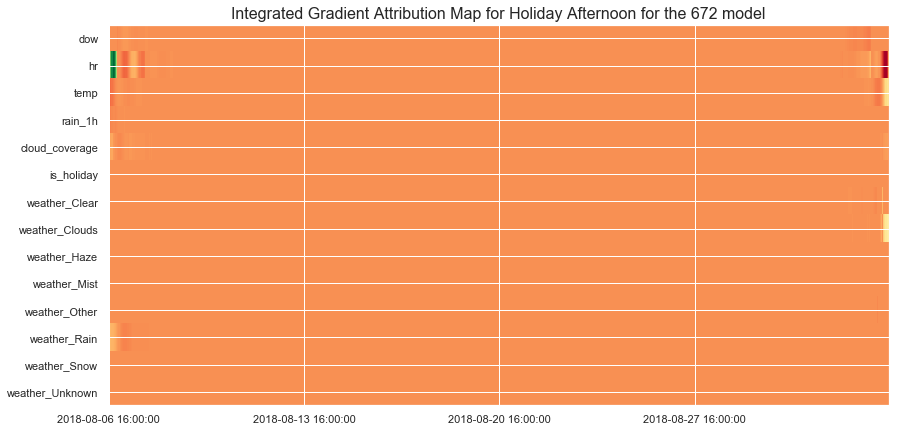

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


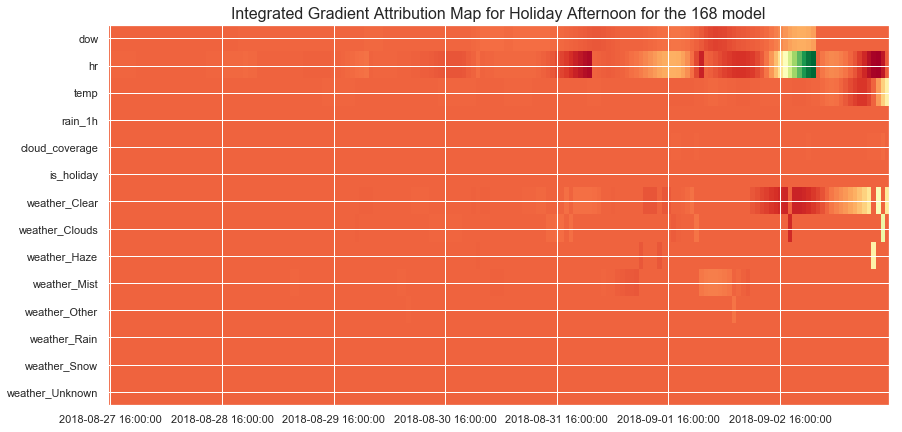

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


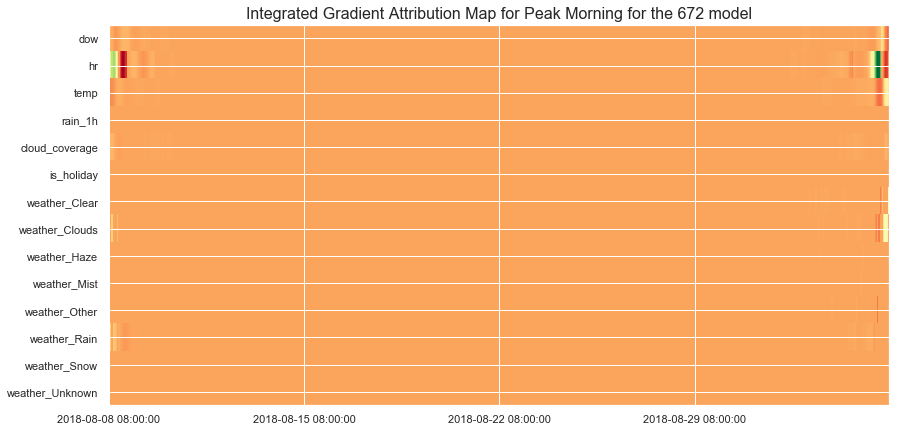

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


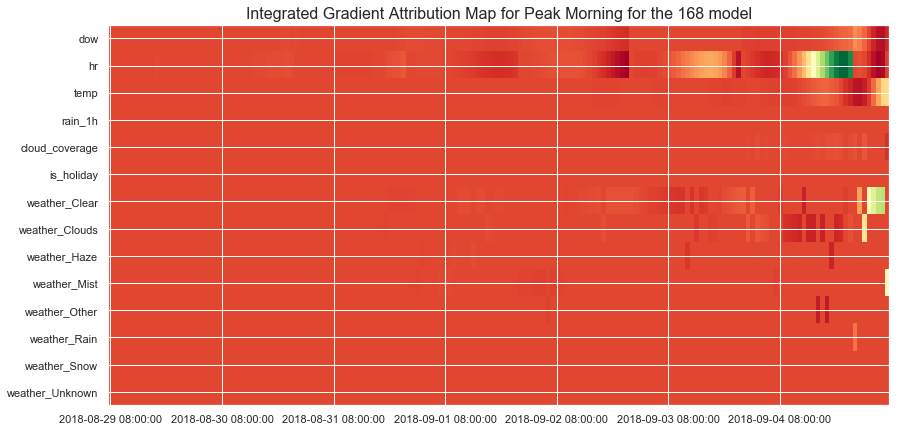

CPU times: user 6min 39s, sys: 5min 4s, total: 11min 43s
Wall time: 4min 43s


In [336]:
%%time
samples = [holiday_afternoon_s, peak_morning_s]
sample_names = ['Holiday Afternoon', 'Peak Morning']
igs = [ig_672, ig_168]
lbs = [672, 168]

for s in range(len(samples)):
    for i in range(len(igs)):
        
        nidx = samples[s].index.tolist()[0] - lb
        lb = lbs[i]
        if lb == 672:
            batch_X = gen_all_672[nidx//24][0]
            p = 5 #Create 5 tick marks...
            f = '7D' #seperated by 1 week periods
        else:
            batch_X = gen_all_168[nidx//24][0]
            p = 8 #Create 8 tick marks...
            f = '1D' #seperated by 1 day periods
            
        explanation = igs[i].explain(batch_X,\
                        baselines=None, target=None)
        attributions = explanation.attributions
        
        end_date = traffic_df.iloc[samples[s].index].\
                                index.to_pydatetime()[0]
        date_range = pd.date_range(end=end_date, periods=p,\
                            freq=f).to_pydatetime().tolist()
        columns = samples[s].columns.tolist()
        attribution_img = np.transpose(attributions[nidx%24,:,:])
        
        plt.figure(figsize=(14,7))
        plt.title('Integrated Gradient Attribution Map for {} for the {} model'.\
                  format(sample_names[s], lb), fontsize=16)
        plt.imshow(attribution_img, interpolation='nearest',\
                                           aspect='auto', cmap='RdYlGn')
        plt.xticks([*range(0,lb,int(lb/(p-1)))], labels=date_range)
        plt.yticks([*range(14)], labels=columns)
        plt.show()

In [186]:
lookback=672
gen_all = gen_all_672
lstm_traffic_mdl = lstm_traffic_672_mdl

In [187]:
cat_idxs = np.where(traffic_df.drop(['traffic_volume'], axis=1).dtypes != np.float64)[0]
print(cat_idxs)

[ 0  1  5  6  7  8  9 10 11 12 13]


In [188]:
heom_dist = HEOM(X_df.values, cat_idxs)

In [189]:
def filt_fn(X_df, x, lookback):
    #print(x.tolist())
    x_ = x.copy()
    x_[0] = round(x_[0])
    x_[1] = round(x_[1])
    x_[4] = round(x_[4])
    x_[5] = round(x_[5])
    if x_[1] < 0:
        x_[1] = 24 + x_[1]
        x_[0] = x_[0] - 1
    if x_[0] < 0:
        x_[0] = 7 + x_[0]
    x_[6] = round(x_[6])
    x_[7] = round(x_[7])
    x_[8] = round(x_[8])
    x_[9] = round(x_[9])
    x_[10] = round(x_[10])
    x_[11] = round(x_[11])
    x_[12] = round(x_[12])
    x_[13] = round(x_[13])
    #if not (x==x_).all(): print('\t%s' % x_.tolist())
    X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
             (X_df.is_holiday==x_[5]) & (X_df.temp-5<=x_[2]) & (X_df.temp+5>=x_[2])]
    if X_filt_df.shape[0]==0:
        X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
                         (X_df.is_holiday==x_[5]) & (X_df.temp-8<=x_[2]) & (X_df.temp+8>=x_[2])]
    if X_filt_df.shape[0]==0:
        X_filt_df = X_df[(X_df.index >= lookback) & (X_df.dow==x_[0]) & (X_df.hr==x_[1]) &\
                         (X_df.temp-11<=x_[2]) & (X_df.temp+11>=x_[2])]
    return X_filt_df, x_

In [190]:
predict_fn = lambda X: mldatasets.\
                        approx_predict_ts(X, X_df, gen_all, lstm_traffic_mdl,\
                              dist_metric=heom_dist.heom, lookback=lookback,\
                              filt_fn=filt_fn, X_scaler=X_scaler, y_scaler=y_scaler)

In [191]:
working_season_df = traffic_df[lookback:].drop(['traffic_volume'], axis=1).copy()
working_season_df = working_season_df[(working_season_df.index.month >= 5) &\
                                      (working_season_df.index.month <= 10)]

In [192]:
%%time
explainer = shap.KernelExplainer(predict_fn,\
                                 shap.kmeans(working_season_df.values, 10))

CPU times: user 11.6 s, sys: 1.87 s, total: 13.5 s
Wall time: 4.99 s


In [193]:
%%time
X_samp_df = working_season_df.sample(48, random_state=rand)
shap_values = explainer.shap_values(X_samp_df, nsamples=5)

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.795e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.613e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.262e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.684e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 


CPU times: user 38min 8s, sys: 6min 5s, total: 44min 14s
Wall time: 14min 57s


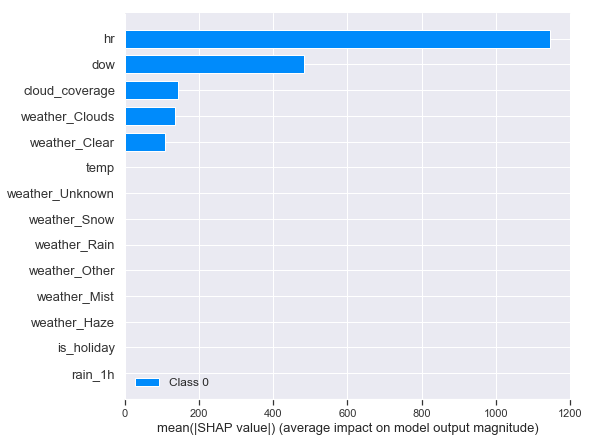

In [194]:
shap.summary_plot(shap_values, X_samp_df)

In [195]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_samp_df)

In [196]:
datapoints = [holiday_afternoon_s, peak_morning_s, hot_saturday_s]
datapoint_labels = ['Holiday Afternoon', 'Peak Morning', 'Hot Saturday']

Holiday Afternoon


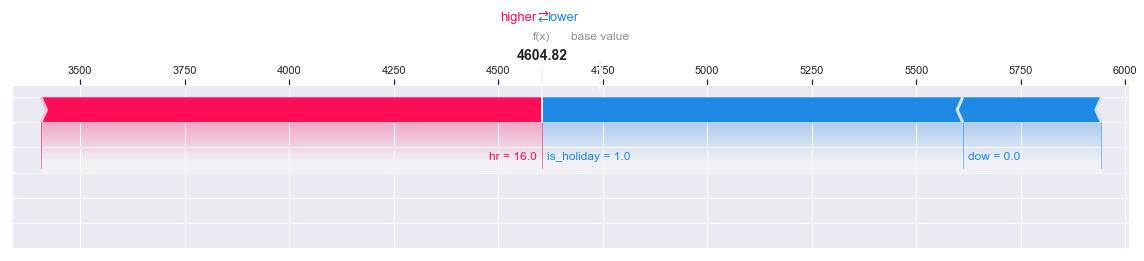

Peak Morning


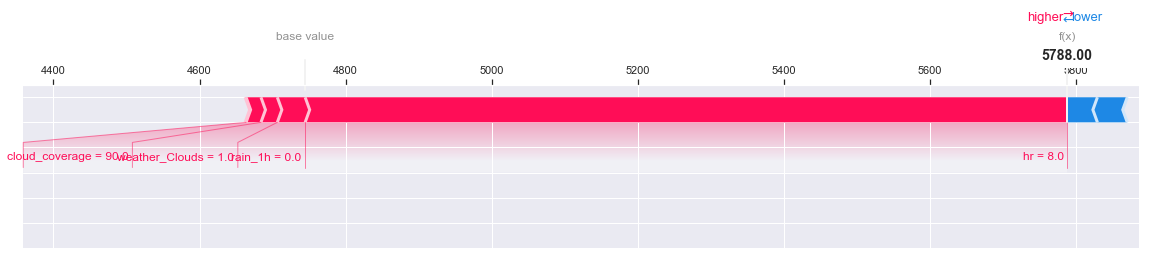

Hot Saturday


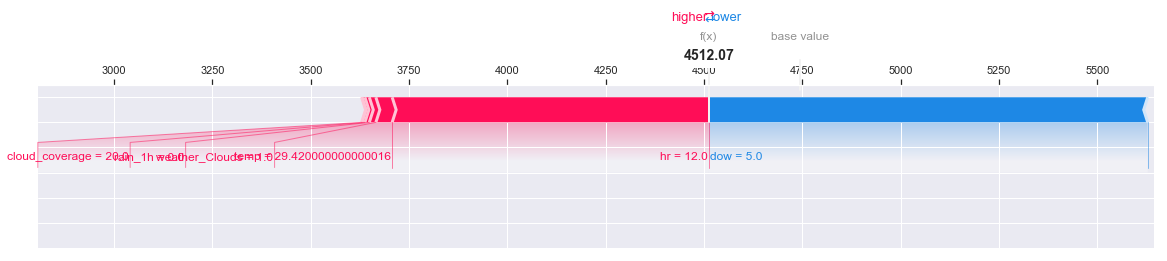

In [197]:
for i in range(len(datapoints)):
    print(datapoint_labels[i])
    shap_values_single = explainer.shap_values(datapoints[i], nsamples=60)
    shap.force_plot(explainer.expected_value, shap_values_single[0],\
                    datapoints[i], matplotlib=True)
    plt.show()

In [198]:
working_hrs_df = working_season_df[(working_season_df.dow < 5) &\
                                   ((working_season_df.hr < 5) |\
                                    (working_season_df.hr > 22))]
working_hrs_df.describe(percentiles=[.025,.5,.975]).transpose().style.set_properties(**{
    'font-size': '10pt',
})

,count,mean,std,min,2.5%,50%,97.5%,max
dow,2232.000000,1.991935,1.415458,0.000000,0.000000,2.000000,4.000000,4.000000
hr,2232.000000,5.500000,7.933780,0.000000,0.000000,2.500000,23.000000,23.000000
temp,2232.000000,16.026438,5.380406,-2.570000,3.178750,16.935000,24.476750,30.458000
rain_1h,2232.000000,0.099628,0.603634,0.000000,0.000000,0.000000,1.451250,10.920000
cloud_coverage,2232.000000,29.178763,36.701417,0.000000,0.000000,1.000000,90.000000,100.000000
is_holiday,2232.000000,0.037634,0.190353,0.000000,0.000000,0.000000,1.000000,1.000000
weather_Clear,2232.000000,0.432348,0.495513,0.000000,0.000000,0.000000,1.000000,1.000000
weather_Clouds,2232.000000,0.207885,0.405885,0.000000,0.000000,0.000000,1.000000,1.000000
weather_Haze,2232.000000,0.010753,0.103159,0.000000,0.000000,0.000000,0.000000,1.000000
weather_Mist,2232.000000,0.104391,0.305835,0.000000,0.000000,0.000000,1.000000,1.000000


In [199]:
morris_problem = {
    # There are nine variables
    'num_vars': 9,
    # These are their names
    'names': ['dow', 'hr', 'temp', 'rain_1h',\
              'cloud_coverage', 'is_holiday',\
              'weather_Clear', 'weather_Clouds',\
              'weather_Rain'],
    # Plausible ranges over which we'll move the variables
    'bounds': [[0, 4], # dow
               [-1, 4], # hr
               [3., 25.], # temp (C)
               [0., 1.5], # rain_1h
               [0., 90.], # cloud_coverage
               [0, 1], # is_holiday
               [0, 1], # weather_Clear 
               [0, 1], # weather_Clouds 
               [0, 1] # weather_Rain
              ],
    # I don't want to group any of these variables together
    'groups': ['dow', 'hr', 'temp', 'rain_1h',\
              'cloud_coverage', 'is_holiday',\
               'weather', 'weather', 'weather']
}

In [200]:
morris_sample = ms.sample(morris_problem, 300,\
                          num_levels=4, seed=rand)
print(morris_sample.shape)

(2400, 9)


In [201]:
morris_sample_mod = np.hstack((morris_sample[:,0:8],\
                       np.zeros((morris_sample.shape[0],3)),\
                       morris_sample[:,8:9],\
                       np.zeros((morris_sample.shape[0],2))))
print(morris_sample_mod.shape)

(2400, 14)


In [202]:
morris_preds = mldatasets.\
                    approx_predict_ts(morris_sample_mod, X_df, gen_all,\
                              lstm_traffic_mdl, filt_fn=filt_fn,\
                              dist_metric=heom_dist.heom, lookback=lookback,
                              X_scaler=X_scaler, y_scaler=y_scaler,\
                              progress_bar=True)

In [203]:
morris_sensitivities = ma.analyze(morris_problem, morris_sample,\
                                  morris_preds, print_to_console=False)

In [204]:
morris_df = pd.DataFrame({'features':morris_sensitivities['names'],\
                          'μ':morris_sensitivities['mu'],\
                          'μ*':morris_sensitivities['mu_star'],\
                          'σ':morris_sensitivities['sigma']})
morris_df.sort_values('μ*', ascending=False).style.\
    background_gradient(cmap='plasma', subset=['μ*']).set_properties(**{
    'font-size': '12pt',
})

,features,μ,μ*,σ
1,hr,-429.300110,1455.506958,1544.544312
5,is_holiday,-345.794861,379.520477,588.769897
0,dow,130.311508,336.568451,554.439819
2,temp,62.087799,202.984299,422.309845
6,weather,nan,75.732839,nan
3,rain_1h,-2.807377,30.730101,113.262093
4,cloud_coverage,9.897467,17.152805,74.319984


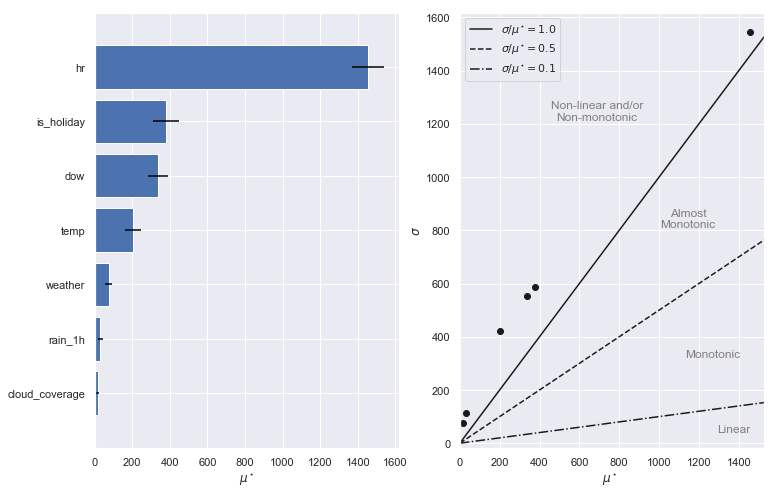

In [205]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,8))
mp.horizontal_bar_plot(ax0, morris_sensitivities, {})
mp.covariance_plot(ax1, morris_sensitivities, {})
ax1.text(ax1.get_xlim()[1]*0.45, ax1.get_ylim()[1]*0.75,\
         'Non-linear and/or\nNon-monotonic',\
         horizontalalignment='center', color='gray')
ax1.text(ax1.get_xlim()[1]*0.75, ax1.get_ylim()[1]*0.5,\
         'Almost\nMonotonic', horizontalalignment='center',\
         color='gray')
ax1.text(ax1.get_xlim()[1]*0.83, ax1.get_ylim()[1]*0.2,\
         'Monotonic', horizontalalignment='center', color='gray')
ax1.text(ax1.get_xlim()[1]*0.9, ax1.get_ylim()[1]*0.025,\
         'Linear', horizontalalignment='center', color='gray')
plt.show()

In [206]:
sobol_problem = {
    'num_vars': 7,
    'names': ['dow', 'hr', 'temp', 'rain_1h',\
              'cloud_coverage', 'is_holiday',\
              'weather_Clear'],
    'bounds': [[0, 4], # dow
               [-1, 4], # hr
               [-3., 31.], # temp (C)
               [0., 11.], # rain_1h
               [0., 100.], # cloud_coverage
               [0, 1], # is_holiday
               [0, 1] # weather_Clear
              ],
    'groups': None
}

In [209]:
saltelli_sample = ss(sobol_problem, 300, calc_second_order=True,\
                     seed=rand)
saltelli_sample_mod = np.hstack((saltelli_sample,\
                       np.zeros((saltelli_sample.shape[0],7))))
print(saltelli_sample_mod.shape)

(4800, 14)


In [210]:
saltelli_preds = mldatasets.\
                    approx_predict_ts(saltelli_sample_mod, X_df, gen_all,\
                              lstm_traffic_mdl, filt_fn=filt_fn,\
                              dist_metric=heom_dist.heom, lookback=lookback,
                              X_scaler=X_scaler, y_scaler=y_scaler,\
                              progress_bar=True)

In [211]:
print(max(saltelli_preds[:,0]))

1879.7686


In [212]:
costs = np.where(saltelli_preds > 1500, 1,0)[:,0]

In [213]:
factor_fixing_sa = sa(sobol_problem, costs,\
                      calc_second_order=True, print_to_console=False)

In [214]:
sobol_df = pd.DataFrame({'features':sobol_problem['names'],\
                          '1st':factor_fixing_sa['S1'],\
                          'Total':factor_fixing_sa['ST'],\
                          'Total Conf':factor_fixing_sa['ST_conf'],\
                          'Mean of Input':saltelli_sample.mean(axis=0)[0:7]})
sobol_df.sort_values('Total', ascending=False).style.\
    background_gradient(cmap='plasma', subset=['Total']).set_properties(**{
    'font-size': '12pt',
})

,features,1st,Total,Total Conf,Mean of Input
1,hr,0.009185,0.886824,0.912979,1.495931
2,temp,0.006123,0.506757,0.660847,14.059766
0,dow,0.009185,0.380068,0.366337,1.995599
5,is_holiday,0.003062,0.380068,0.479628,0.498047
6,weather_Clear,-0.003062,0.126689,0.314201,0.499023
3,rain_1h,0.000000,0.000000,0.000000,5.511458
4,cloud_coverage,0.000000,0.000000,0.000000,50.024740


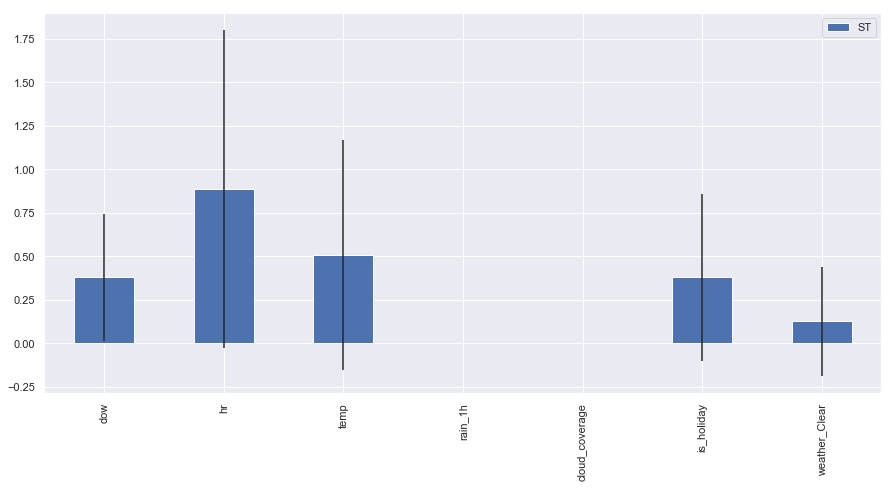

In [215]:
factor_fixing_df = factor_fixing_sa.to_df()
fig, (ax) = plt.subplots(1,1, figsize=(15, 7))
barplot(factor_fixing_df[0], ax=ax)
plt.show()

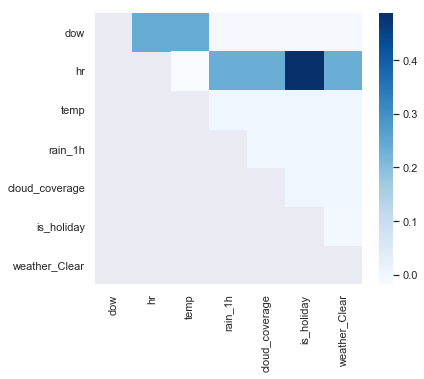

In [216]:
plt.figure(figsize=(6, 5))
sns.heatmap(factor_fixing_sa['S2'], cmap='Blues',\
            xticklabels=sobol_problem['names'],\
            yticklabels=sobol_problem['names'])
plt.show()

In [217]:
saltelli_sample_preds = np.hstack((saltelli_sample, saltelli_preds))
print(saltelli_sample_preds.shape)

(4800, 8)


In [218]:
def cost_fn(x):
    cost = 0
    if x[7] > 1500:
        cost = (x[7] - 1500) * 15
        if round(x[1]) == 4:
            cost = cost + 1500
            if round(x[0]) == 4:    
                cost = cost + 4500
    return cost

costs2 = np.array([cost_fn(xi) for xi in saltelli_sample_preds])
print(sum(costs2))

119014.44213867188


In [219]:
factor_fixing2_sa = sa(sobol_problem, costs2,\
                       calc_second_order=True, print_to_console=False)

In [220]:
sobol2_df = pd.DataFrame({'features':sobol_problem['names'],\
                          '1st':factor_fixing2_sa['S1'],\
                          'Total':factor_fixing2_sa['ST'],\
                          'Total Conf':factor_fixing2_sa['ST_conf'],\
                          'Mean of Input':saltelli_sample.mean(axis=0)[0:7]})
sobol2_df.sort_values('Total', ascending=False).style.\
    background_gradient(cmap='plasma', subset=['Total']).set_properties(**{
    'font-size': '12pt',
})

,features,1st,Total,Total Conf,Mean of Input
5,is_holiday,0.000852,0.953684,3.509326,0.498047
1,hr,0.010101,0.748595,1.132665,1.495931
2,temp,0.000677,0.552892,0.843215,14.059766
0,dow,0.009874,0.514826,0.452778,1.995599
6,weather_Clear,-0.002776,0.121222,0.404481,0.499023
4,cloud_coverage,-0.000000,0.000000,0.000000,50.024740
3,rain_1h,-0.000000,0.000000,0.000000,5.511458


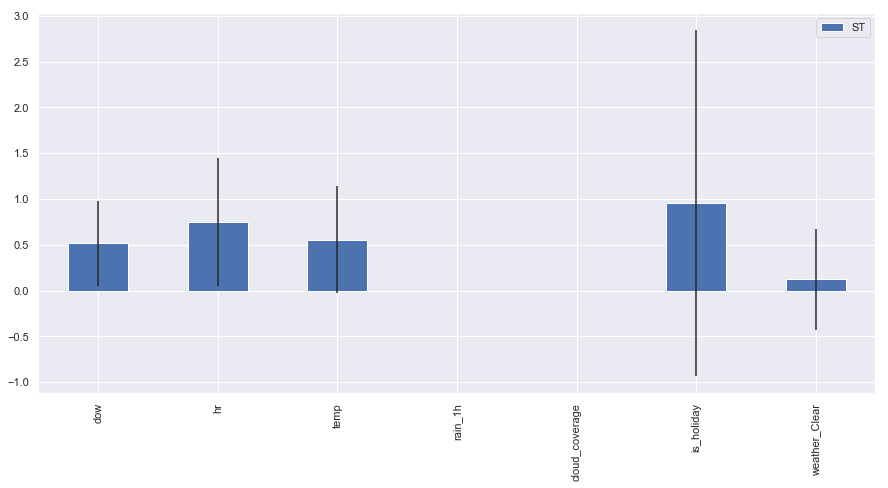

In [351]:
factor_fixing2_df = factor_fixing2_sa.to_df()
fig, (ax) = plt.subplots(1,1, figsize=(15, 7))
barplot(factor_fixing2_df[0], ax=ax)
plt.show()

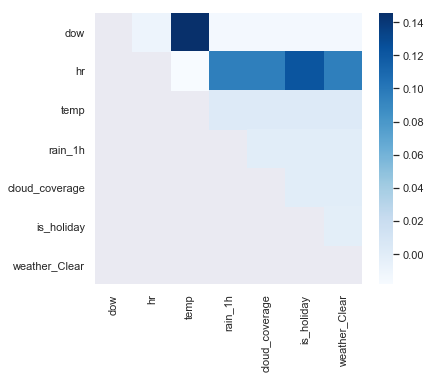

In [353]:
plt.figure(figsize=(6, 5))
sns.heatmap(factor_fixing2_sa['S2'], cmap='Blues',\
            xticklabels=sobol_problem['names'],\
            yticklabels=sobol_problem['names'])
plt.show()